#Data Analysis#

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
schedules_df = pd.read_excel('/content/drive/MyDrive/Synthesis Project I/Data/Schedules.xlsx')
data_df = pd.read_excel('/content/drive/MyDrive/Synthesis Project I/Data/Data.xlsx')
clients_df = pd.read_excel('/content/drive/MyDrive/Synthesis Project I/Data/Clients.xlsx')
transl_cost_pairs_df = pd.read_excel('/content/drive/MyDrive/Synthesis Project I/Data/TranslatorsCost+Pairs.xlsx')




In [ ]:
# data_df['HOURS'] = data_df['HOURS'].str.replace(',', '.').astype(float)

 **Data Overview**

In [ ]:
print("\nDataFrame Info:")
print(db.info())

print("\nStatistics:")
print(db.describe())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554029 entries, 0 to 554028
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   PROJECT_ID                   554029 non-null  object        
 1   PM                           554029 non-null  object        
 2   TASK_ID                      554029 non-null  int64         
 3   START                        554029 non-null  object        
 4   END                          554029 non-null  datetime64[ns]
 5   TASK_TYPE                    554029 non-null  object        
 6   SOURCE_LANG                  554029 non-null  object        
 7   TARGET_LANG                  554029 non-null  object        
 8   TRANSLATOR                   554029 non-null  object        
 9   ASSIGNED                     554029 non-null  datetime64[ns]
 10  READY                        554029 non-null  datetime64[ns]
 11  WORKING  

In [ ]:
# Missing Values Analysis
import matplotlib.pyplot as plt

missing = db.isnull().sum()
print("Missing values per column:")
print(missing)



Missing values per column:
PROJECT_ID                     0
PM                             0
TASK_ID                        0
START                          0
END                            0
TASK_TYPE                      0
SOURCE_LANG                    0
TARGET_LANG                    0
TRANSLATOR                     0
ASSIGNED                       0
READY                          0
WORKING                        0
DELIVERED                      0
RECEIVED                       0
CLOSE                          0
HOURS                          0
HOURLY_RATE                    0
COST                           0
QUALITY_EVALUATION             0
MANUFACTURER                   5
MANUFACTURER_SECTOR            5
MANUFACTURER_INDUSTRY_GROUP    5
MANUFACTURER_INDUSTRY          5
MANUFACTURER_SUBINDUSTRY       5
dtype: int64


In [ ]:
#Convert into datetime objects
date_columns = ["START", "END", "ASSIGNED", "READY", "WORKING", "DELIVERED", "RECEIVED", "CLOSE"]
for col in date_columns:
    if col in db.columns:
        db[col] = pd.to_datetime(db[col], errors="coerce")
        print(f"{col} converted.")
    else:
        print(f"{col} not found.")


START converted.
END converted.
ASSIGNED converted.
READY converted.
WORKING converted.
DELIVERED converted.
RECEIVED converted.
CLOSE converted.


In [ ]:
#Create new columns

# work duration
if {"WORKING", "DELIVERED"}.issubset(db.columns):
    db["Work_Duration_minutes"] = (db["DELIVERED"] - db["WORKING"]).dt.total_seconds() / 60
#delay
if {"DELIVERED", "END"}.issubset(db.columns):
    db["Delay_minutes"] = (db["DELIVERED"] - db["END"]).dt.total_seconds() / 60

#Process Time
if {"ASSIGNED", "CLOSE"}.issubset(db.columns):
    db["Process_Time_minutes"] = (db["CLOSE"] - db["ASSIGNED"]).dt.total_seconds() / 60

cols = ["TASK_ID", "Work_Duration_minutes", "Delay_minutes", "Process_Time_minutes"] if "TASK_ID" in db.columns else ["Work_Duration_minutes", "Delay_minutes", "Process_Time_minutes"]
print("New Metrics Sample:")
print(db[cols].head())


New Metrics Sample:
    TASK_ID  Work_Duration_minutes  Delay_minutes  Process_Time_minutes
0  10048285               0.033333    -341.516667              3.983333
1  10048285           44581.833333    -362.383333          50172.766667
2  10048285            1386.550000     342.350000           1441.250000
3  10048285              75.666667     140.116667             77.416667
4  10048286               0.083333    -341.950000              3.550000


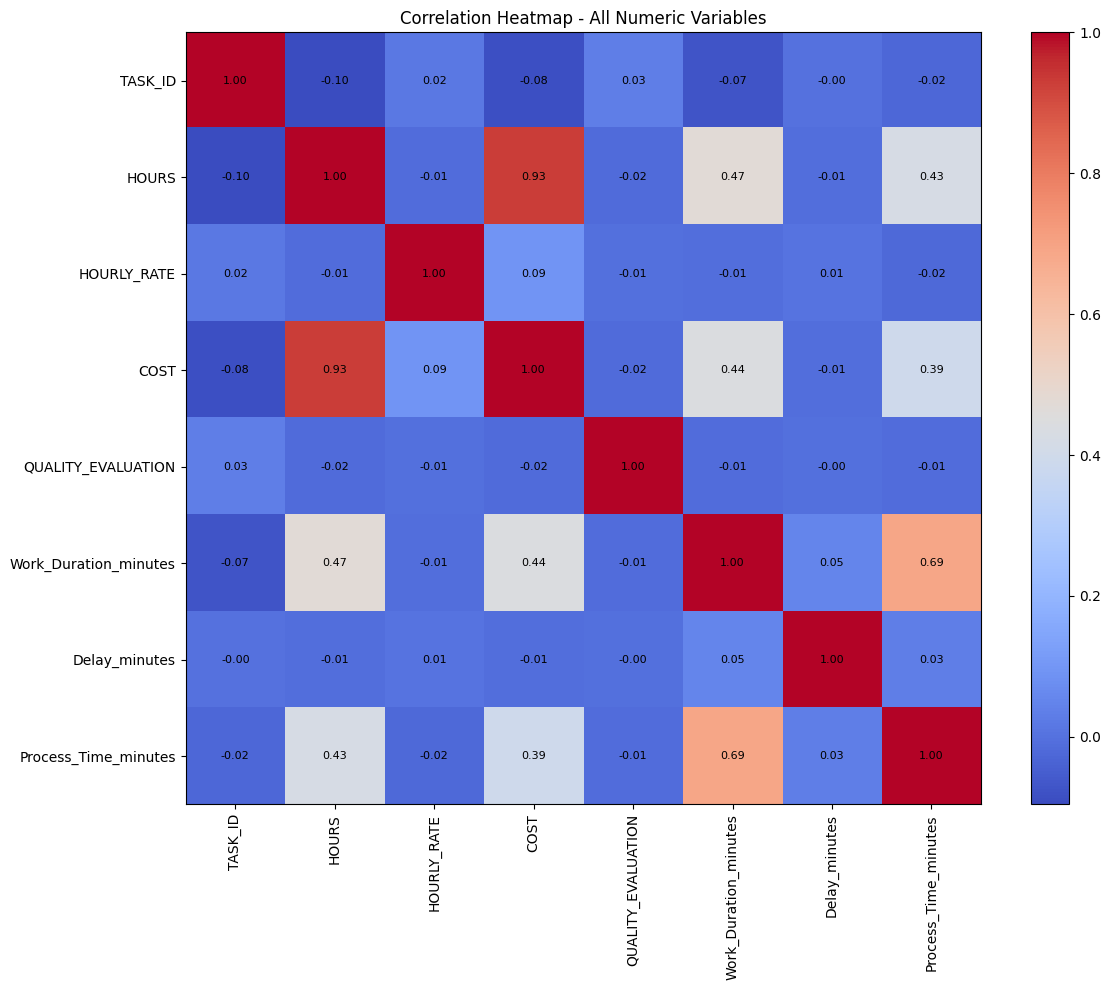

In [ ]:

#Correlation Heat map of all Numeric Variables

numeric_df = db.select_dtypes(include=[np.number])
corr_full = numeric_df.corr()

plt.figure(figsize=(12,10))
plt.imshow(corr_full, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_full.columns)), corr_full.columns, rotation=90)
plt.yticks(range(len(corr_full.index)), corr_full.index)
plt.title("Correlation Heatmap - All Numeric Variables")
for (i, j), val in np.ndenumerate(corr_full):
    plt.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=8)
plt.tight_layout()
plt.show()


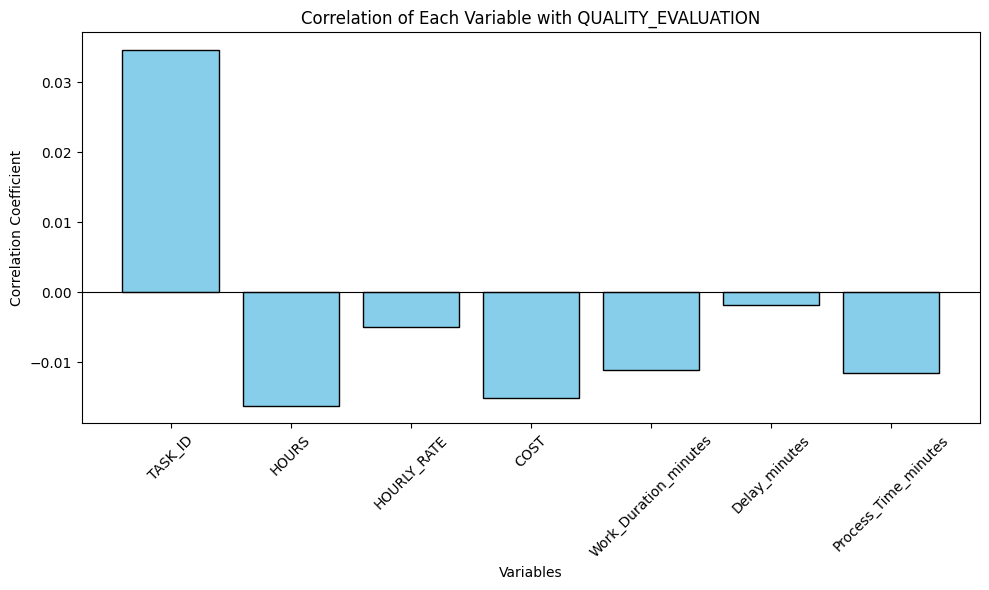

In [ ]:
# correlations of each variable with QUALITY_EVALUATION
target = "QUALITY_EVALUATION"
other_vars = [col for col in numeric_df.columns if col != target]

correlations = {var: db[var].corr(db[target]) for var in other_vars}

plt.figure(figsize=(10, 6))
plt.bar(correlations.keys(), correlations.values(), color='skyblue', edgecolor='black')
plt.title("Correlation of Each Variable with QUALITY_EVALUATION")
plt.xlabel("Variables")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


Numeric variables: ['HOURLY_RATE', 'COST', 'QUALITY_EVALUATION', 'Work_Duration_minutes', 'Delay_minutes', 'Process_Time_minutes']


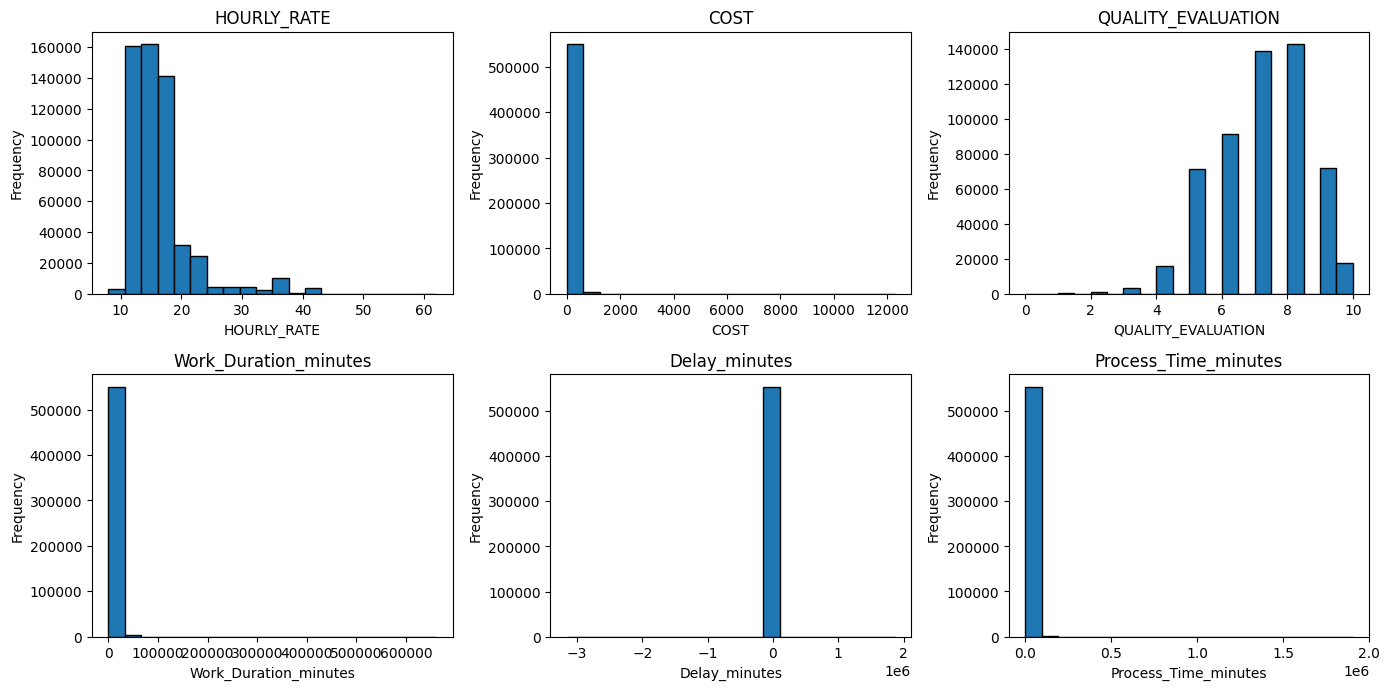

In [ ]:
#Distribution of variables
import matplotlib.pyplot as plt

numeric_vars = [var for var in ["HOURS", "HOURLY_RATE", "COST", "QUALITY_EVALUATION", "Work_Duration_minutes", "Delay_minutes", "Process_Time_minutes"] if var in db.columns]
print("Numeric variables:", numeric_vars)

plt.figure(figsize=(14, 10))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 3, i)
    plt.hist(db[var].dropna(), bins=20, edgecolor="black")
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



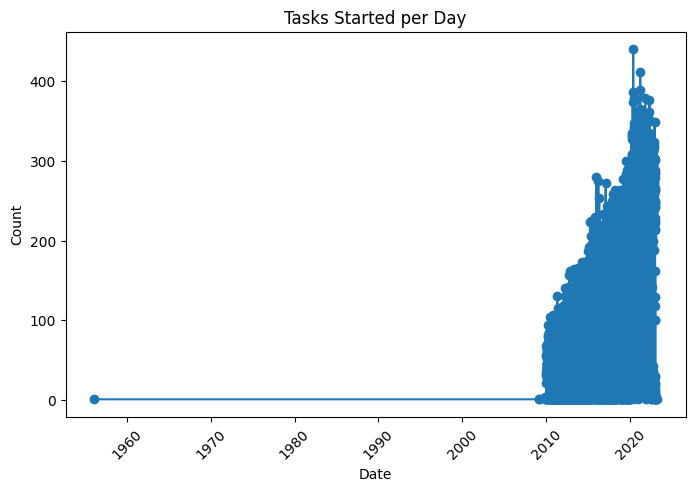

In [ ]:
#Number of tasks started each day
if "START" in db.columns:
    db["Start_Date"] = db["START"].dt.date
    tasks_per_day = db.groupby("Start_Date").size()
    plt.figure(figsize=(8, 5))
    plt.plot(tasks_per_day.index, tasks_per_day.values, marker="o")
    plt.title("Tasks Started per Day")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("START column not found.")


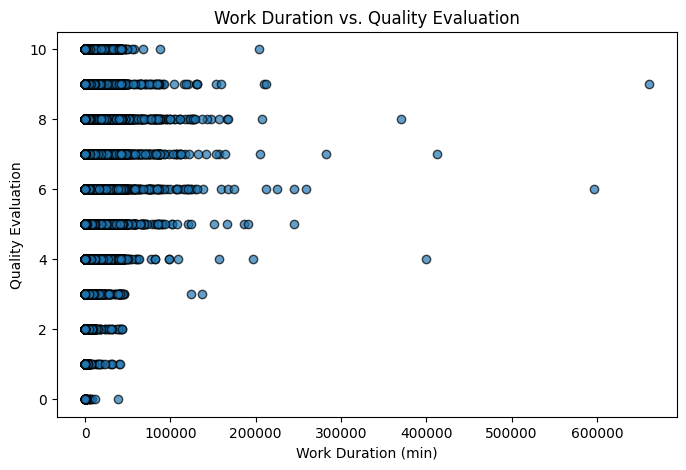

In [ ]:
#Speed and Quality distribution
if {"Work_Duration_minutes", "QUALITY_EVALUATION"}.issubset(db.columns):
    plt.figure(figsize=(8, 5))
    plt.scatter(db["Work_Duration_minutes"], db["QUALITY_EVALUATION"], alpha=0.7, edgecolor="black")
    plt.title("Work Duration vs. Quality Evaluation")
    plt.xlabel("Work Duration (min)")
    plt.ylabel("Quality Evaluation")
    plt.show()
else:
    print("Work_Duration_minutes and/or QUALITY_EVALUATION missing.")

<ipython-input-34-d1229615ad35>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=types, patch_artist=True)


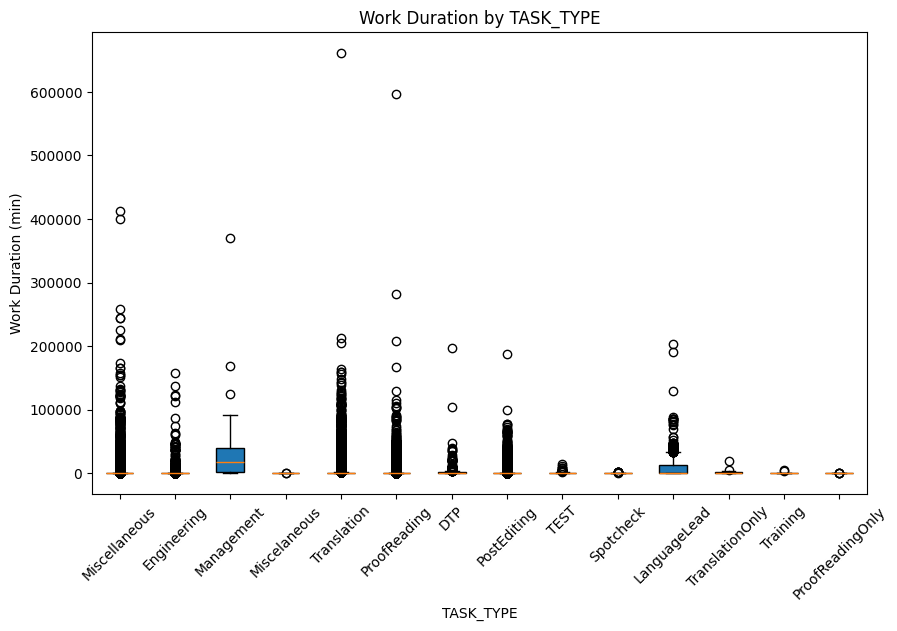

In [ ]:
#Correlation task type with speed
if {"Work_Duration_minutes", "TASK_TYPE"}.issubset(db.columns):
    plt.figure(figsize=(10, 6))
    types = db["TASK_TYPE"].unique()
    data = [db[db["TASK_TYPE"] == t]["Work_Duration_minutes"].dropna() for t in types]
    plt.boxplot(data, labels=types, patch_artist=True)
    plt.title("Work Duration by TASK_TYPE")
    plt.xlabel("TASK_TYPE")
    plt.ylabel("Work Duration (min)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Columns for Work Duration boxplot missing.")

<ipython-input-35-00a766784e36>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=types, patch_artist=True)


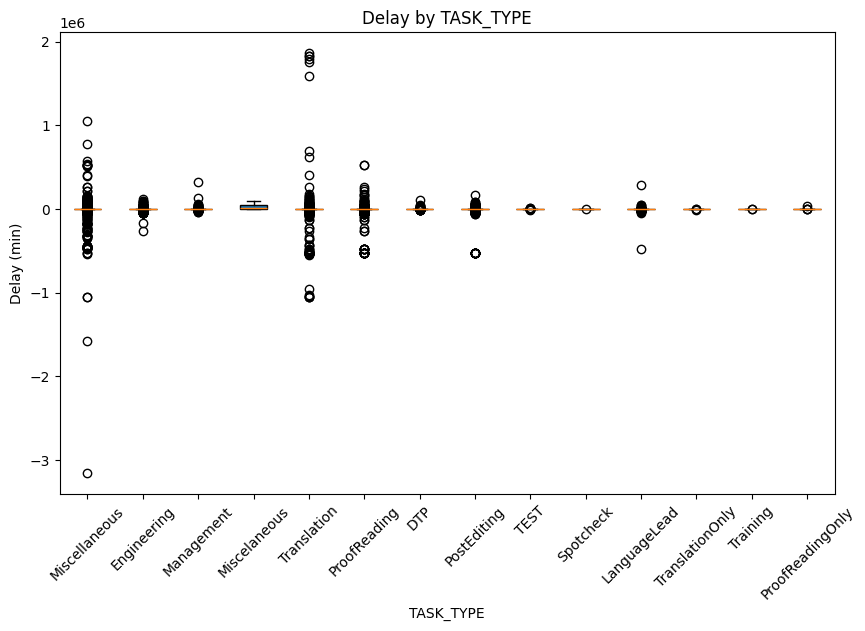

In [ ]:
#correlation taks type with delay
if {"Delay_minutes", "TASK_TYPE"}.issubset(db.columns):
    plt.figure(figsize=(10, 6))
    data = [db[db["TASK_TYPE"] == t]["Delay_minutes"].dropna() for t in types]
    plt.boxplot(data, labels=types, patch_artist=True)
    plt.title("Delay by TASK_TYPE")
    plt.xlabel("TASK_TYPE")
    plt.ylabel("Delay (min)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Columns for Delay boxplot missing.")

In [ ]:
# Precision Score: 1/(1 + |Delay_minutes|)
if "Delay_minutes" in db.columns:
    db["Precision_Score"] = 1 / (1 + db["Delay_minutes"].abs())
    print("Precision_Score calculated.")
    print(db[["TASK_ID", "Delay_minutes", "Precision_Score"]].head())
else:
    print("Delay_minutes column is missing.")


Precision_Score calculated.
    TASK_ID  Delay_minutes  Precision_Score
0  10048285    -341.516667         0.002920
1  10048285    -362.383333         0.002752
2  10048285     342.350000         0.002912
3  10048285     140.116667         0.007086
4  10048286    -341.950000         0.002916


In [ ]:
#Translator Performance Summary when it comes to Experience, speed, price, quatlity, delay and precision
translator_summary = db.groupby("TRANSLATOR").agg(
    Experience=('TASK_ID', 'count'),
    Avg_Work_Duration=('Work_Duration_minutes', 'mean'),
    Avg_Hourly_Rate=('HOURLY_RATE', 'mean'),
    Avg_Quality=('QUALITY_EVALUATION', 'mean'),
    Avg_Precision=('Precision_Score', 'mean'),
    Avg_Delay=('Delay_minutes', 'mean')
).reset_index()

print("Translator Performance Summary:")
print(translator_summary)


Translator Performance Summary:
             TRANSLATOR  Experience  Avg_Work_Duration  Avg_Hourly_Rate  \
0                 Aaron           2           2.358333        15.000000   
1                 Abdon          27        4006.680247        14.407407   
2          Abdon Isaias        3769        1970.814261        16.979836   
3            Abdon Luis           1        7514.300000        17.000000   
4            Abel Irene           2        1565.925000        12.000000   
..                  ...         ...                ...              ...   
866      Zacarias Casio         189        4836.515344        12.936508   
867  Zacarias Marcelino          32        3913.777604        12.343750   
868             Zachary          15        6906.070000        27.533333   
869              Zlatan          11        1790.395455        44.000000   
870              Zlatko           1        1177.900000        28.000000   

     Avg_Quality  Avg_Precision    Avg_Delay  
0       5.500000    

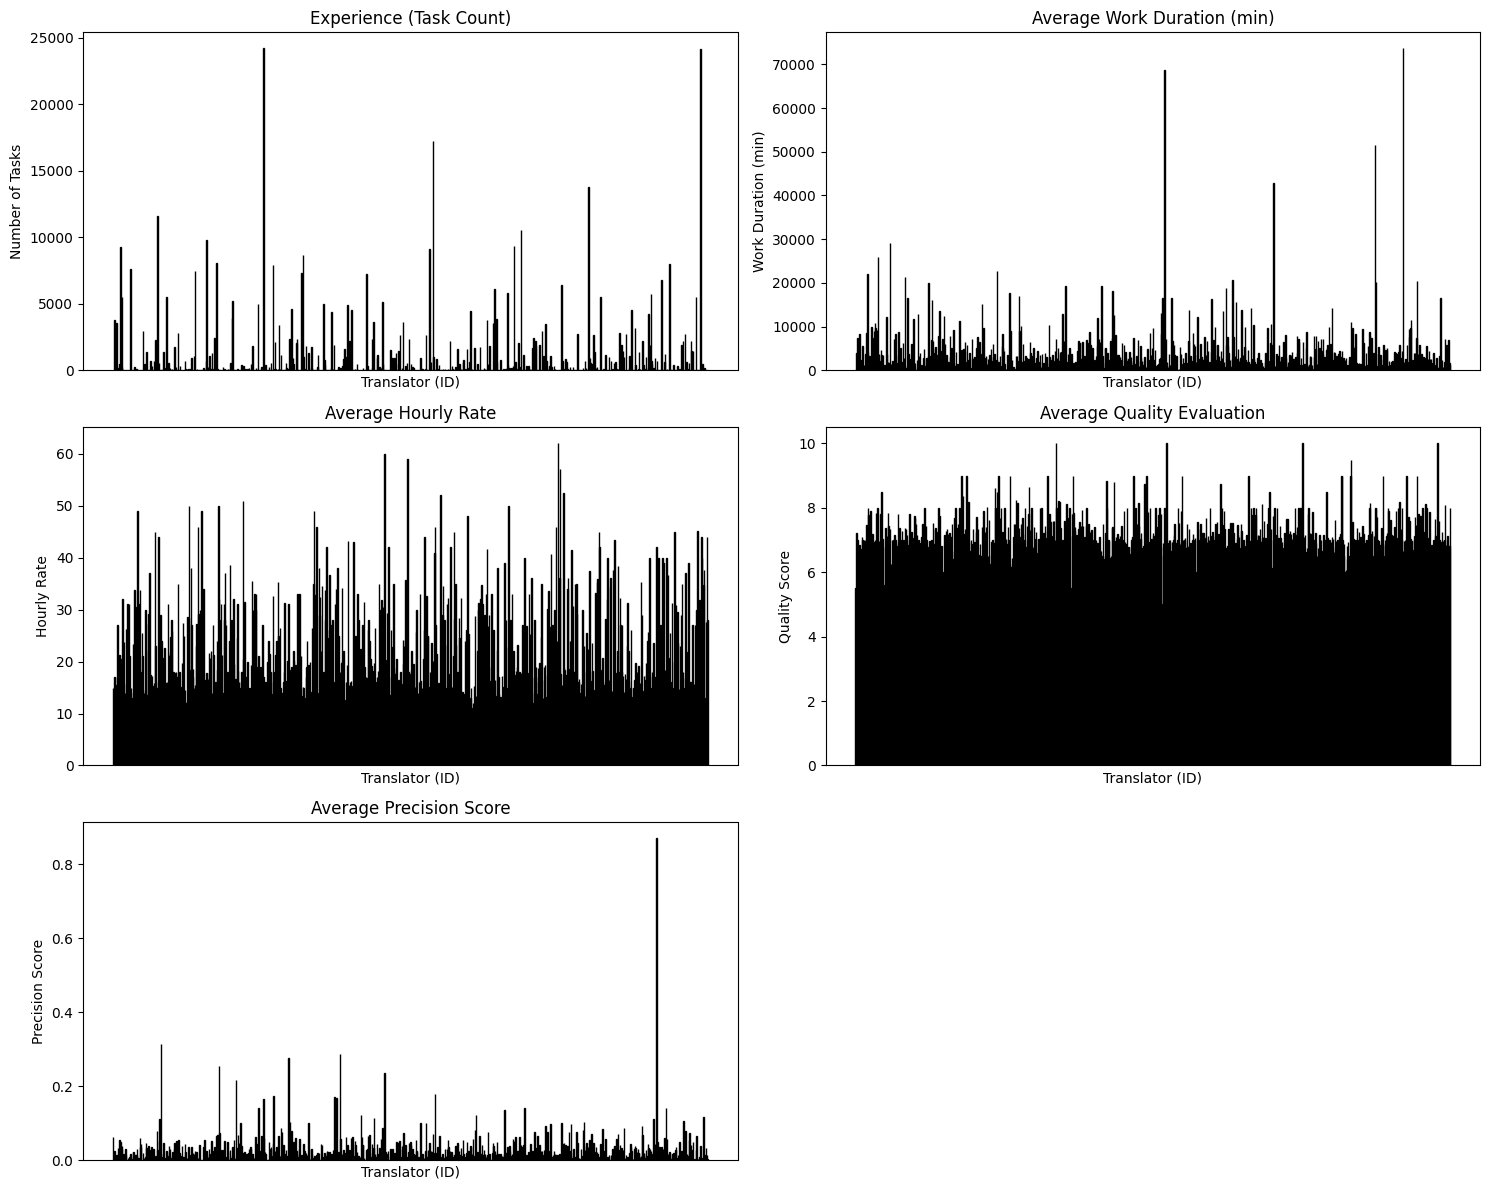

In [ ]:
#Plot the Tranlator distribution with variables: Experience, speed, price, quatlity, and precision
import matplotlib.pyplot as plt

indices = range(len(translator_summary))

plt.figure(figsize=(15, 12))

# Experience
plt.subplot(3, 2, 1)
plt.bar(indices, translator_summary["Experience"], color='skyblue', edgecolor="black")
plt.title("Experience (Task Count)")
plt.xlabel("Translator (ID)")
plt.ylabel("Number of Tasks")
plt.xticks([])

# speed
plt.subplot(3, 2, 2)
plt.bar(indices, translator_summary["Avg_Work_Duration"], color='lightgreen', edgecolor="black")
plt.title("Average Work Duration (min)")
plt.xlabel("Translator (ID)")
plt.ylabel("Work Duration (min)")
plt.xticks([])

#  price
plt.subplot(3, 2, 3)
plt.bar(indices, translator_summary["Avg_Hourly_Rate"], color='salmon', edgecolor="black")
plt.title("Average Hourly Rate")
plt.xlabel("Translator (ID)")
plt.ylabel("Hourly Rate")
plt.xticks([])

#  grade
plt.subplot(3, 2, 4)
plt.bar(indices, translator_summary["Avg_Quality"], color='plum', edgecolor="black")
plt.title("Average Quality Evaluation")
plt.xlabel("Translator (ID)")
plt.ylabel("Quality Score")
plt.xticks([])

# Precision
plt.subplot(3, 2, 5)
plt.bar(indices, translator_summary["Avg_Precision"], color='gold', edgecolor="black")
plt.title("Average Precision Score")
plt.xlabel("Translator (ID)")
plt.ylabel("Precision Score")
plt.xticks([])

plt.tight_layout()
plt.show()
